In [21]:
# Solution to problem set 1   course Building a Robot Judge  Prof E Ash ETHZ  due date 21 Mar 2019  submitted by Heman Tanos tanosh@student.ethz.ch

In [324]:
import numpy as np

import csv
import pandas as pd
import os
from datetime import time 
from datetime import datetime
import matplotlib.pyplot as plt

from string import punctuation
translator = str.maketrans(' ', ' ', punctuation)
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')


In [325]:
def normalize_text(doc):                # taken from past problem set     see comment under question 3
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ') 
        lower = sent.lower()
        nopunc = lower.translate(translator)
        words = nopunc.split()
        nostop = [w for w in words if w not in stoplist]
        no_numbers = [w if not w.isdigit() else '#' for w in nostop]
        stemmed = [stemmer.stem(w) for w in no_numbers]
        tokens += stemmed
    return tokens


In [329]:
df = pd.DataFrame(index = range(0,0), columns=['jahr',  'rev', 'nsents', 'nwords', 'nlets', 'nnouns', 'nverbs', 'nadjes', 'tgs'], 
                  dtype = int)
df['tgs'] = df['tgs'].astype('object')  # tgs is a list of trigrams

fpath = '/home/xhta/Robot/cases'   # !!!!!! this path must be modified to point to the folder where the cases are located (texts)

lrev = []	#list of reversed cases   
lnrev = []	#list of not reversed cases

print ("reading in cases_reversed.txt")
with open ("/home/xhta/Robot/cases_reversed.txt") as fcrev:
    readCSV = csv.reader(fcrev, delimiter = ',')
    next(readCSV, None)   # skip 1 line   don't skip in case of 96  only skip in the orig
    for Zei in readCSV:
        if (Zei[1] == '0'): lnrev.append(Zei[0])
        else: lrev.append(Zei[0])

print ("done reading in cases_reversed.txt")

reading in cases_reversed.txt
done reading in cases_reversed.txt


In [330]:
n_samples = 1000   # !!!!!!!!!!!!!!!!!!! to be set from run to run !!!!!!!!!   1000 was suggested in the problem set
# run time is long when setting n_samples to 1000 (> 1 hour)
n_rev = len(lrev)  # the n_samples samples are composed in the same proportion of reversed/nonreversed cases as in the full corpus
n_nrev = len(lnrev)
n_all = n_rev + n_nrev

n_samples_rev = int(np.ceil(n_samples * n_rev/n_all))
n_samples_nrev = n_samples - n_samples_rev

samples_rev_caseid = np.random.choice(lrev, n_samples_rev, replace = False)
samples_nrev_caseid = np.random.choice(lnrev, n_samples_nrev, replace = False)

for caseid_nrev in samples_nrev_caseid:      # populate the index with the case ID  and the column 'rev' 
    df.loc[caseid_nrev] = [0, 0, 0, 0, 0, 0, 0, 0, [ ]]

for caseid_rev in samples_rev_caseid:
    df.loc[caseid_rev] = [0, 1, 0, 0, 0, 0, 0, 0, [ ]]

print ("done inserting caseid and rev into dataframe")

from os import listdir
from os.path import isfile, join

fnames = [f for f in listdir(fpath) if isfile(f)]

ldir = listdir(fpath)


done inserting caseid and rev into dataframe


In [331]:
import spacy                   #  initializing data structures used later
from spacy.lang.en import English
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

nlp2 = spacy.load('en_core_web_sm')

from nltk import ngrams
from collections import Counter
term_frequencies = Counter()

totalgrams = []

i = 0

In [332]:
for fname in ldir:            # read in the document samples and populate the dataframe
    lae = len(fname)
    cname = fname[5:(lae-4)]
    year = fname[0:4]
    if (not (cname in df.index)): continue

    if ( i% 199 ==0):
        print(datetime.now().strftime('%Y%m%d_%H:%M:%S'))   # serves as a "progress bar" when reading in a large # of docs
    df.at[cname, 'jahr'] =  year
    i = i + 1
    fna2 = join(fpath, year + '_' + cname + '.txt')
    rawtext = open(fna2).read()
    doc = nlp(rawtext)
    df.at[cname, 'nlets'] =  len(rawtext)
    sentences = [sent.string.strip() for sent in doc.sents]
    df.at[cname, 'nsents'] =  len(sentences)
    df.at[cname, 'nwords'] = len([token for token in doc if not token.is_punct])
    doc2 = nlp2(rawtext)
    df.at[cname, 'nnouns'] = len([w for w in list(doc2) if w.tag_.startswith('N')]) # PTB convention
    df.at[cname, 'nverbs'] = len([w for w in list(doc2) if w.tag_.startswith('V')])
    df.at[cname, 'nadjes'] = len([w for w in list(doc2) if w.tag_.startswith('J')])
    cltoks = normalize_text(doc2)
    ntoks = [str(token).lower() for token in list(doc2) if (token.tag_.startswith('N')) & (not token.is_punct) & (not token.is_space) & (not token.is_stop) & (str(token) in cltoks)]
    trigrams = ngrams(cltoks, 3)
    grams = []
    for t in trigrams:
        lt = list(t)
        if(lt[2] in ntoks): grams += ['_'.join(t)]
    df.at[cname, 'tgs'] = grams
    totalgrams += grams
    term_frequencies.update(cltoks)

print ("finished populating data frame")

20190320_05:53:06
20190320_06:03:39
20190320_06:13:14
20190320_06:31:56
20190320_06:49:37
20190320_07:08:59
finished populating data frame


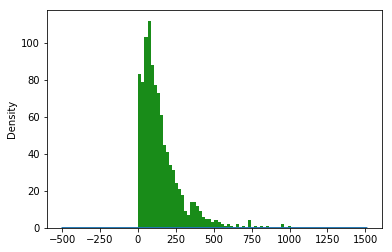

In [333]:
# Question 1 : historgrams
df['nsents'].hist(bins=50, color = 'green', alpha = 0.9)    # histogram over number of sentences
df['nsents'].plot(kind='kde')
plt.show()

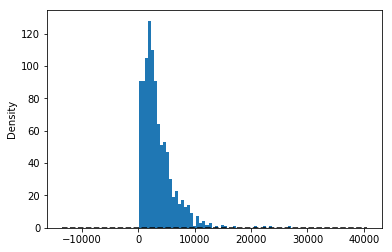

In [334]:
df['nwords'].hist(bins=50)    # histogram over number of words
df['nwords'].plot(kind='kde', style = 'k--')

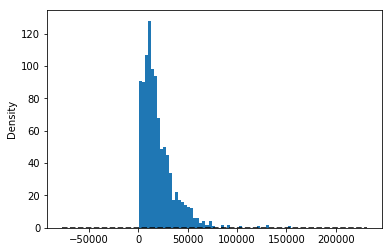

In [335]:
df['nlets'].hist(bins=50)    # histogram over number of letters
df['nlets'].plot(kind='kde', style = 'k--')

In [336]:
df.head()

,jahr,rev,nsents,nwords,nlets,nnouns,nverbs,nadjes,tgs
X3R2LF,1954.0,0.0,34.0,980.0,5773.0,275.0,127.0,36.0,"[nativ_belgium_citizen, citizen_franc_law, apr..."
X426CR,1967.0,0.0,286.0,4870.0,28689.0,1649.0,607.0,277.0,"[judg_petit_review, review_five_order, certain..."
XAFGAF,1986.0,0.0,240.0,5729.0,33368.0,1871.0,718.0,254.0,"[judg_lynn_file, lynn_file_suit, file_suit_she..."
X3P6PG,1980.0,0.0,152.0,3081.0,18404.0,933.0,477.0,179.0,"[circuit_judg_appeal, sohio_summari_judgment, ..."
X421DO,1964.0,0.0,541.0,10440.0,59870.0,3040.0,1530.0,532.0,"[judg_two_member, member_unit_state, congress_..."


In [337]:
# Question 2 number of nouns/verbs/adjectives in document 
#  documents are indexed by their respective caseid
#  number of nouns in document with case id  X2S1O7 is df.loc['X2S1O7', 'nnouns']  analogous with verbs/adjectives

# aggregate by year to plot the frequencies 
df.groupby('jahr')['rev', 'nsents', 'nwords', 'nlets', 'nnouns', 'nverbs', 'nadjes'].sum()

,rev,nsents,nwords,nlets,nnouns,nverbs,nadjes
jahr,,,,,,,
1924.0,0.0,202.0,5733.0,33141.0,1606.0,841.0,384.0
1925.0,2.0,404.0,12956.0,71857.0,3845.0,1796.0,614.0
1926.0,7.0,1076.0,28851.0,160832.0,8266.0,4283.0,1531.0
1927.0,6.0,252.0,7518.0,41966.0,2187.0,1074.0,373.0
1928.0,2.0,274.0,7017.0,39212.0,2095.0,1077.0,311.0
1929.0,1.0,504.0,12205.0,66842.0,3570.0,1672.0,609.0
1930.0,8.0,864.0,24032.0,134106.0,6586.0,3459.0,1319.0
1931.0,4.0,648.0,17974.0,99381.0,5438.0,2536.0,808.0
1932.0,2.0,973.0,25023.0,139798.0,7442.0,3481.0,1220.0


In [338]:
gby = df.groupby('jahr')['rev', 'nsents', 'nwords', 'nlets', 'nnouns', 'nverbs', 'nadjes'].sum()

<Figure size 432x288 with 0 Axes>

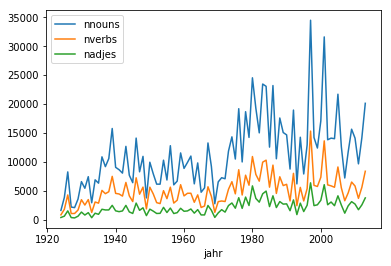

In [339]:
# still Question 2 : plot the frequencies of nouns, verbs and adjectives by year
plt.clf()
df.groupby('jahr')['nnouns', 'nverbs', 'nadjes'].sum().plot(kind='line')
plt.show()

In [340]:
# Question 3 : normalization to remove noise because noise distorts the statistics
# CR anf LF are replaced by spaces because readCSV appends CR and LF to the end of a line
# further, punctuation marks and stopwords are considered noise and removed
# last, words are stemmed   e.g. works, worked, working --> work, boy, boys, boy's -> boy

In [341]:
# Question 4. df3 is a new dataframe with 1000 trigrams as features (the trigrams end with a noun)
n_feats = 1000          # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from collections import Counter
tgc = Counter(totalgrams)
mc = tgc.most_common()[0:n_feats]
lmc = len(mc)

# df3 includes the targets/labels because need to do logisticregression later
feats = ['rev']
for j in range(lmc):
    tu = tgc.most_common()[j]
    fea = tu[0]
    feats.append(fea)

df3 = pd.DataFrame(index = df.index, columns=feats, dtype = int)
df3['rev'] = df['rev']
df3 = df3.astype({"rev": int})
#pkl_fname = 'df3.' + datetime.now().strftime('%Y%m%d_%H%M%S' + ".pkl")
#df3.to_pickle(pkl_fname)
# save a a pickle for later use

In [342]:
for loca in df.index:
    tgs = df.loc[loca, 'tgs']
    for feat in feats:
        if (feat == 'rev'): continue
        df3.at[loca, feat] = tgs.count(feat)

In [343]:
 # elapse time  starttime = time.time()     elapsed time = time.time() - starttime
# Question 5: apply LogisticRegression from sklearn on the training data set and make prediction
# using the training / test data set to compare the accuracy score / the F1 score

from sklearn import preprocessing

target = df3['rev']
features = df3.loc[:,df3.columns != 'rev']

features_scaled = preprocessing.scale(features, with_mean=False)
msk = np.random.rand(len(df3)) < 0.8      
# split into 80 % training set and 20% test set

# training set
targeta = target[msk]
feata = features_scaled[msk]

# test set
targete = target[~msk]
feate = features_scaled[~msk]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 123, solver = 'liblinear').fit(feata, targeta)

ypreda = clf.predict(feata)
yprede = clf.predict(feate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
  # accuracy on training data
  # accuracy on test data
print(accuracy_score(targeta, ypreda), accuracy_score(targete, yprede))
# print out accuracy when predicting using the training set vs when using the test set

0.9783989834815756 0.539906103286385


In [344]:
  # print out F1 when using training data to predict vs when usinh test data to predict
print(f1_score(targeta, ypreda), f1_score(targete, yprede) )


0.9834146341463414 0.6397058823529412


In [345]:
confusion_matrix(targeta, ypreda)  # cm on training data

array([[266,  17],
       [  0, 504]])

In [346]:
confusion_matrix(targete, yprede)  # cm on test data

array([[28, 56],
       [42, 87]])

In [347]:
# Question 6
#from sklearn import grid_search, # deprecated
from sklearn import model_selection
parameters = {'penalty':('l1', 'l2'), 'C':[1, 2, 5, 10]}

#clf2 = grid_search.GridSearchCV(clf, parameters)
#clf2.fit(feata, targeta)
#clf2.best_params_

clf3 = model_selection.GridSearchCV(clf, parameters)
clf3.fit(feata, targeta)
clf3.best_params_

{'C': 2, 'penalty': 'l2'}

In [348]:
df5.head()

,cs
X47SP3,0.7448
X419VV,-0.9123
X3TM4H,-0.9716
X4S7L1,1.0000
X36D0G,0.9977


In [349]:
# Question 7 
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df5 = pd.DataFrame(index = df.index, columns=['cs'], dtype = int)
#for fname in ldir[0:10]:
for fname in ldir:
    lae = len(fname)
    cname = fname[5:(lae-4)]
    if (not (cname in df5.index)): continue
    year = fname[0:4]
    fna2 = join(fpath, year + '_' + cname + '.txt')
    rawtext = open(fna2).read()
    #doc = nlp(rawtext)
    #doc2 = nlp2(rawtext)
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(rawtext)
    df5.loc[cname] = [ss['compound']]

In [350]:
# print the sentences with the first 10 highest compound vader score
print(df5.nlargest(10, 'cs'))

             cs
X50OTD      1.0
X1JU8VU003  1.0
XA6QJD      1.0
XGA2V2      1.0
X42JRH1     1.0
X50H17      1.0
X38966      1.0
X46J08      1.0
X43SRP      1.0
X50MTC      1.0


In [351]:
# print the sentences with the first 10 smallest compound vader score
print(df5.nsmallest(10, 'cs'))

             cs
X13JKD0003 -1.0
X3PA9N     -1.0
XAFIOO     -1.0
XACA92     -1.0
XACBQL     -1.0
X16EP04003 -1.0
X1ABKE0003 -1.0
X50KBS     -1.0
X1L0PJO003 -1.0
X39MBB     -1.0


In [352]:
# question 8: compute tfidf vectors and cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer

dfvec = pd.DataFrame(index = range(0,0), columns=['jahr',  'rev', 'text', 'cluster', 'tgs'], dtype = int)
dfvec['jahr'] = df['jahr']
dfvec['rev'] = df['rev']
dfvec['tgs'] = df['tgs']
dfvec['text'] = dfvec['text'].astype('object')
dfvec['rev'] = dfvec['rev'].astype('int')

for fname in ldir:
    lae = len(fname)
    cname = fname[5:(lae-4)]
    year = fname[0:4]
    if (not (cname in df.index)): continue
    fna2 = join(fpath, year + '_' + cname + '.txt')
    rawtext = open(fna2).read()
    #nlp3 = spacy.load('en')
    #doc = nlp3(rawtext)
    #sentences = [sent.string.strip() for sent in doc.sents]
    #doc2 = nlp2(rawtext)
    dfvec.at[cname, 'text'] = rawtext

#vec = TfidfVectorizer(min_df = 0.001, max_df = 0.8, max_features = 4000, stop_words = 'english', use_idf = True, ngram_range = (1,3))
#vec = TfidfVectorizer(min_df = 0.0001, max_df = 0.4, max_features = 40000, stop_words = 'english') # good
vec = TfidfVectorizer(min_df = 0.001, max_df = 0.4, max_features = 4000, stop_words = 'english', use_idf = True, ngram_range = (3,3))
trainedVec = vec.fit_transform (dfvec['text'])

In [353]:
trainedVec.shape

(1000, 4000)

In [354]:
from sklearn.metrics.pairwise import cosine_similarity

# compute cosine similarity between sentences
cs = cosine_similarity(trainedVec[0:n_samples], trainedVec)
top10similar = cs.argsort()[:-10:-1]
top10dissimilar = cs.argsort()[0:10:]
print ("top 10 similar")
print (top10similar)
print ("top 10 dissimilar")
print (top10dissimilar)

top 10 similar
[[499 443 827 ... 888 118 999]
 [  0 716 717 ... 473 986 998]
 [999 474 476 ... 631 570 997]
 ...
 [541 304 762 ... 289  83 993]
 [  0 605 606 ... 972 677 992]
 [  0 592 593 ... 243 950 991]]
top 10 dissimilar
[[499 553 554 ... 614 347   0]
 [  0 553 555 ... 393 181   1]
 [  0 533 532 ... 971 843   2]
 ...
 [  0 646 647 ... 889 265   7]
 [  0 546 548 ... 957 240   8]
 [251 716 717 ... 961 522   9]]


In [355]:
# the following are the top 10 groups of similar documents
print ([dfvec.index[i] for i in top10similar])

[Index(['X41IM9', 'X3T41M', 'X41F9V', 'X4432F', 'XABKEN', 'X3U7MQ', 'X45PD5',
       'X21KR0', 'X46HCA', 'X3VACO',
       ...
       'X40G1M', 'X3U2BS', 'X416GL', 'X2VAKD', 'X4LPVI', 'X4A7NT', 'X497EO',
       'X3R7IQ', 'X4UUKN', 'X3TNVV'],
      dtype='object', length=1000), Index(['X3R2LF', 'X3PB8E', 'X43SRP', 'X3RLIL', 'X9VEHG', 'X3N3AQ', 'X485TU',
       'X408CM', 'X3NV0E', 'X42BM7',
       ...
       'X3IL66', 'X3IA83', 'X40G1M', 'X1BO53I003', 'X1K6P18003', 'X4K9H3',
       'X3FJJV', 'X2AHUJ', 'X3IS32', 'X30NDI'],
      dtype='object', length=1000), Index(['X3TNVV', 'X3T1VK', 'X30J8N', 'X46VFR', 'XA6ROR', 'X3IIIR', 'X3T1LK',
       'X3PO6P', 'X3RS4H', 'X41S8A',
       ...
       'X3AOV8', 'X3P7JE', 'XAC8A9', 'X3S6U4', 'X426FV', 'X30IRN', 'X41NVS',
       'X492VM', 'X420VP', 'X48SOC'],
      dtype='object', length=1000), Index(['X3R2LF', 'X2NF60', 'X1CC9T4003', 'X3MF16', 'X44C5E', 'X3TUDM',
       'X3BFI2', 'X3SL22', 'X3OLMJ', 'X42L31',
       ...
       'X3Q9R2', 'X44HMD', 'X3DBMK

In [356]:
# the following are the top 10 groups of dissimilar documents
print ([dfvec.index[i] for i in top10dissimilar])

[Index(['X41IM9', 'X3N515', 'XABL1E', 'X3CEPF', 'X3BVJ5', 'X407M5', 'X3U87O',
       'X3TM6L', 'X45800', 'X48V6E',
       ...
       'X3UET9', 'X407KM', 'X3DTQO', 'X4973V', 'X42JDA', 'X3MU0E', 'X41GAS',
       'X36BDK', 'X44H9T', 'X3R2LF'],
      dtype='object', length=1000), Index(['X3R2LF', 'X3N515', 'X3AP4P', 'X407M5', 'X3U87O', 'X3TM6L', 'X45800',
       'X3HVR5', 'X3GODE', 'X3UIIR',
       ...
       'X3U7MQ', 'X3TGN8', 'X3T4EE', 'X3H472', 'X57G8D', 'X3II5U', 'X40Q5D',
       'X4AMCJ', 'X41QCK', 'X426CR'],
      dtype='object', length=1000), Index(['X3R2LF', 'X164AGE003', 'X50R46', 'X41RLB', 'X43SU4', 'X3NN7H',
       'X40IUR', 'X46BP1', 'X3OUNR', 'X40876',
       ...
       'X41G5J', 'X37IPE', 'X32IPL', 'X3RLJ6', 'X4B62S', 'X3T8HT', 'X41G9G',
       'X1VT1V', 'X41SA8', 'XAFGAF'],
      dtype='object', length=1000), Index(['X41IM9', 'X4AMAS', 'X410ML', 'X448DJ', 'X46J7F', 'X3IUPI', 'X2AJ6C',
       'X40843', 'X42N97', 'X3IRDU',
       ...
       'X3T1R8', 'X3NRIC', 'X41O51', 'X3SI

In [357]:
# Question 9  kmeans clustering
n_clusters = 20
from sklearn.cluster import KMeans
km = KMeans(n_clusters = n_clusters, n_jobs = -1)

km.fit(trainedVec)
clusters = km.labels_.tolist()

In [358]:
# print out 5 documents in each of the n_clusters clusters
for cl_id in range(n_clusters):
    inde = np.where(arry_cl == cl_id)[0]
    print("rank:", cl_id, [dfvec.index[j] for j in inde[0:5]])
    #for j in range(5): print(dfvec.index[inde[j]])

rank: 0 ['X4A2BF', 'X3II5U', 'X49321', 'X44J0K', 'X497EO']
rank: 1 ['X4DHVL', 'X13JKD0003', 'X41T1A', 'XAFHAM', 'X3N51N']
rank: 2 ['X3OTBQ', 'X3PAAF', 'X3ITJ9', 'X3L40B', 'X3H472']
rank: 3 ['X3U0KO', 'X3TI9D', 'X3ID26', 'X3CNG5', 'X41O6B']
rank: 4 ['X3BOHV', 'X356J4', 'X4B5O2', 'X3IQ22', 'X3TE38']
rank: 5 ['X421DO', 'X3IVS4', 'XAC70D', 'X50OTD', 'X3BRD2']
rank: 6 ['X3R2LF', 'X3GOCU', 'X3DTQO', 'X3ICPF', 'X47M5G']
rank: 7 ['X3CIDB', 'X3BIV7', 'X6BK6E', 'X3VTM6', 'X3TV2M']
rank: 8 ['X3P6PG', 'X350VA', 'X1IUFJM003', 'X3D90S', 'X4872M']
rank: 9 ['X44EJ3', 'X3F69N', 'X3AD6A', 'X3SPH8', 'X3OKKT']
rank: 10 ['X3P6QR', 'X3V6FN', 'X3U6QC', 'X498PJ', 'X18R8I2003']
rank: 11 ['X3H304', 'X3UDVA', 'X46MD8', 'X3ADNK', 'X43QAA']
rank: 12 ['X426CR', 'X9VAVQ', 'X32IPL', 'X2K4GN', 'X3O772']
rank: 13 ['X41G9G', 'X354AU', 'X3T7AP', 'X3DPCS', 'X3JGBE']
rank: 14 ['XAFGAF', 'X3BAHU', 'X3GCP6', 'X42BH4', 'X48FBR']
rank: 15 ['X3TKHD', 'X468B5', 'X1BR3N4003', 'X4168R', 'XABK8T']
rank: 16 ['XA6S6Q', 'X3H4Q0', 'X40